In [1]:
import sys
import os

import pandas as pd
import numpy as np

import statistics
import re
import logging

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split

In [2]:
sys.path.append('lib')

from train_models import prepare_training, train_classifiers
from predict_labels import BARModels
from bar_tools import plot_confusion_matrix

In [3]:
logger = logging.getLogger()
logger.setLevel('INFO')

## Set up paths and parameters

In [4]:
in_path = '../data_syn/annotated_data_example.tsv'  # path to training data
models_dir = '../saved_models'

In [5]:
dictionary_paths = {'personnames_path': '../data_syn//dictionaries/personnames.tsv',
                    'placenames_path': '../data_syn/dictionaries/schweizer_ortsnamen-wikipedia.csv',
                    'firmnames_path': '../data_syn/dictionaries/firmnames_unigrams.tsv',
                    'commonwords_path': '../data_syn/dictionaries/deu_news_2010_1M-words-LOWER.tsv'}

In [6]:
anno_field = 'TITEL'
context_field = 'HIERARCHIE'
id_field = 'IDENTIFIER'
context_window = '4'

## Prepare Data

In [7]:
# read data into data frame
in_df = pd.read_csv(in_path, sep='\t')
in_df

,IDENTIFIER,HIERARCHIE,TITEL
0,ID-1,Straffälle\n - \n - \n - und Ausfuhrregelung...,"YU: <j>Vahuret</j>, Givisiez CH-FR"
1,ID-2,"Informelles, Vorprüfung, Prüfung und Rechtsmit...","<j>Emacite, S.A.</j> (<wd>7.4.</wd> - <wd>31.5..."
2,ID-3,Dossier N 141000 - 141999\n - Asyldossiers\n -...,<n>Anopug</n> . <d>14.03.1976</d>
3,ID-4,Benutzer \n - Benützer (LfNr) / Standort der...,<n>Presseservice Epihu GmbH</n>
4,ID-5,Allgemeine Personalfragen; Personaldossiers\n ...,<n>Auyeci unlimited GmbH</n> <d>1968</d>
...,...,...,...
995,ID-996,Divisionsgericht 1\n - Territorialgericht 3 A...,"<n>Yopec, Sàrl</n>, Matr.-Nr. <a>125.76.465</a..."
996,ID-997,Rekurse (nach Laufnummern)\n - Rekurskommissi...,<j>Huwib GmbH</j>
997,ID-998,Asile - Cas particuliers\n - Asyl | Asile\...,"Asile - Cas particuliers - <n>Wupov GmbH</n>, ..."
998,ID-999,Immatrikulationsdossiers | Dossiers d'imma...,"<n>Boulangerie Oseoro, Sàrl</n> <d>06..."


In [8]:
# run feature extraction

((tok_feat_df, tok_anno), (doc_feat_df, doc_anno)) = prepare_training(in_df, dictionary_paths, anno_field=anno_field, context_field=context_field, id_field=id_field)

INFO:root:Number of lines in input data: 1000
INFO:root:Tokenizer initiated
INFO:root:Building feature overview... (This may take some time)


In [9]:
print(tok_feat_df)
print(tok_anno)

      IDENTIFIER  td-idx                                       tok_features
0           ID-1       0  {'token': 'YU', 'pos_fine': 'NE', 'lemma': 'YU...
1           ID-1       1  {'token': ':', 'pos_fine': '$.', 'lemma': ':',...
2           ID-1       2  {'token': 'Vahuret', 'pos_fine': 'NE', 'lemma'...
3           ID-1       3  {'token': ',', 'pos_fine': '$,', 'lemma': ',',...
4           ID-1       4  {'token': 'Givisiez', 'pos_fine': 'NE', 'lemma...
...          ...     ...                                                ...
11655    ID-1000   11655  {'token': '.', 'pos_fine': '$.', 'lemma': '.',...
11656    ID-1000   11656  {'token': '6', 'pos_fine': 'CARD', 'lemma': '6...
11657    ID-1000   11657  {'token': '.', 'pos_fine': '$.', 'lemma': '.',...
11658    ID-1000   11658  {'token': '02', 'pos_fine': 'CARD', 'lemma': '...
11659    ID-1000   11659  {'token': 'Gegenstandslos', 'pos_fine': 'NN', ...

[11660 rows x 3 columns]
      IDENTIFIER  td-idx annotation
0           ID-1       0  

In [22]:
tok_feat_df.iloc[0]['tok_features']

{'token': 'YU',
 'pos_fine': 'NE',
 'lemma': 'YU',
 'lower': 'yu',
 'shape': 'XX',
 'is_alpha': 'True',
 'is_digit': 'False',
 'is_punct': 'False',
 'is_left_punct': 'False',
 'is_right_punct': 'False',
 'like_num': 'False',
 'is_stop': 'False',
 'datecheck': 'False',
 'ahvcheck': 'False',
 'hierarchie': ' Stra',
 'in_personnames': 'False',
 'in_swissplaces': 'False',
 'in_register': 'False',
 'common_words': 'True',
 'length': '2',
 'in_hier:Beziehungen': 'True',
 'in_hier:zu': 'True',
 'in_hier:Ausfuhrregelungen': 'True',
 'in_hier:einzelnen': 'True',
 'in_hier:Straffälle': 'True',
 'in_hier:und': 'True',
 'in_hier:Warenverkehr': 'True',
 'in_hier:Staaten': 'True',
 's_ngram:X': 'True',
 'lower-1': 'BOS',
 'lower+1': ':',
 'pos+1': '$.',
 'is_punct+1': 'True',
 'shape+1': ':',
 'lower-2': 'BOS',
 'lower+2': 'vahuret',
 'pos+2': 'NE',
 'is_punct+2': 'False',
 'shape+2': 'Xxxxx',
 'lower-3': 'BOS',
 'lower+3': ',',
 'pos+3': '$,',
 'is_punct+3': 'True',
 'shape+3': ',',
 'lower-4': 'BO

In [10]:
print(doc_feat_df)
print(doc_anno)

    IDENTIFIER                                       doc_features
0         ID-1  [{'token': 'YU', 'pos_fine': 'NE', 'lemma': 'Y...
1         ID-2  [{'token': 'Emacite', 'pos_fine': 'NN', 'lemma...
2         ID-3  [{'token': 'Anopug', 'pos_fine': 'NN', 'lemma'...
3         ID-4  [{'token': 'Presseservice', 'pos_fine': 'NN', ...
4         ID-5  [{'token': 'Auyeci', 'pos_fine': 'NE', 'lemma'...
..         ...                                                ...
995     ID-996  [{'token': 'Yopec', 'pos_fine': 'NE', 'lemma':...
996     ID-997  [{'token': 'Huwib', 'pos_fine': 'NE', 'lemma':...
997     ID-998  [{'token': 'Asile', 'pos_fine': 'NN', 'lemma':...
998     ID-999  [{'token': 'Boulangerie', 'pos_fine': 'NE', 'l...
999    ID-1000  [{'token': 'Duwev', 'pos_fine': 'ADJA', 'lemma...

[1000 rows x 2 columns]
    IDENTIFIER                                         annotation
0         ID-1                           [O, p, j, p, O, O, p, O]
1         ID-2  [j, j, j, j, j, p, wd, wd, wd, p, w

## Train

In [11]:
doc_ids = doc_anno[id_field]
print(doc_ids.tolist())

['ID-1', 'ID-2', 'ID-3', 'ID-4', 'ID-5', 'ID-6', 'ID-7', 'ID-8', 'ID-9', 'ID-10', 'ID-11', 'ID-12', 'ID-13', 'ID-14', 'ID-15', 'ID-16', 'ID-17', 'ID-18', 'ID-19', 'ID-20', 'ID-21', 'ID-22', 'ID-23', 'ID-24', 'ID-25', 'ID-26', 'ID-27', 'ID-28', 'ID-29', 'ID-30', 'ID-31', 'ID-32', 'ID-33', 'ID-34', 'ID-35', 'ID-36', 'ID-37', 'ID-38', 'ID-39', 'ID-40', 'ID-41', 'ID-42', 'ID-43', 'ID-44', 'ID-45', 'ID-46', 'ID-47', 'ID-48', 'ID-49', 'ID-50', 'ID-51', 'ID-52', 'ID-53', 'ID-54', 'ID-55', 'ID-56', 'ID-57', 'ID-58', 'ID-59', 'ID-60', 'ID-61', 'ID-62', 'ID-63', 'ID-64', 'ID-65', 'ID-66', 'ID-67', 'ID-68', 'ID-69', 'ID-70', 'ID-71', 'ID-72', 'ID-73', 'ID-74', 'ID-75', 'ID-76', 'ID-77', 'ID-78', 'ID-79', 'ID-80', 'ID-81', 'ID-82', 'ID-83', 'ID-84', 'ID-85', 'ID-86', 'ID-87', 'ID-88', 'ID-89', 'ID-90', 'ID-91', 'ID-92', 'ID-93', 'ID-94', 'ID-95', 'ID-96', 'ID-97', 'ID-98', 'ID-99', 'ID-100', 'ID-101', 'ID-102', 'ID-103', 'ID-104', 'ID-105', 'ID-106', 'ID-107', 'ID-108', 'ID-109', 'ID-110', 'ID-111

In [12]:
## train-test split (over document ids): 80% train -- 20% test
docs_train, docs_test = train_test_split(doc_ids, test_size=0.2, random_state=42)
print(len(docs_train), len(docs_test))

800 200


In [13]:
print(docs_train[:10])

29      ID-30
535    ID-536
695    ID-696
557    ID-558
836    ID-837
596    ID-597
165    ID-166
918    ID-919
495    ID-496
824    ID-825
Name: IDENTIFIER, dtype: object


In [14]:
# divide document-level features and annotations into training and test set

in_train_docs = doc_feat_df[id_field].isin(docs_train)

doc_feat_df_train = doc_feat_df[in_train_docs]  # training set features
print(doc_feat_df_train.shape)
doc_anno_train = doc_anno[in_train_docs]
print(doc_anno_train.shape)
print(doc_anno_train)
print(doc_feat_df_train)


doc_feat_df_test = doc_feat_df[~in_train_docs].copy()
doc_anno_test = doc_feat_df[~in_train_docs].copy()
print(doc_anno_test.shape)

(800, 2)
(800, 2)
    IDENTIFIER                                         annotation
0         ID-1                           [O, p, j, p, O, O, p, O]
1         ID-2  [j, j, j, j, j, p, wd, wd, wd, p, wd, wd, wd, ...
2         ID-3                              [n, p, d, d, d, d, d]
3         ID-4                                          [n, n, n]
4         ID-5                                       [n, n, n, d]
..         ...                                                ...
993     ID-994                        [O, O, O, p, O, O, n, n, n]
994     ID-995                                          [n, n, n]
996     ID-997                                             [j, j]
997     ID-998            [O, p, O, O, p, n, n, p, d, d, d, d, d]
999    ID-1000  [j, j, p, O, O, p, O, O, O, O, O, O, O, p, O, ...

[800 rows x 2 columns]
    IDENTIFIER                                       doc_features
0         ID-1  [{'token': 'YU', 'pos_fine': 'NE', 'lemma': 'Y...
1         ID-2  [{'token': 'Emacit

In [15]:
# divide token-level features and annotations into training and test set

in_train_toks = tok_anno[id_field].isin(docs_train)

tok_feat_df_train = tok_feat_df[in_train_toks]
tok_anno_train = tok_anno[in_train_toks]
print(tok_feat_df_train.shape, tok_anno_train.shape)
print(tok_anno_train)
print(tok_feat_df_train)

tok_feat_df_test = tok_feat_df[~in_train_toks].copy()
tok_anno_test = tok_anno[~in_train_toks].copy()
print(tok_anno_test.shape)

(9284, 3) (9284, 3)
      IDENTIFIER  td-idx annotation
0           ID-1       0          O
1           ID-1       1          p
2           ID-1       2          j
3           ID-1       3          p
4           ID-1       4          O
...          ...     ...        ...
11655    ID-1000   11655         wd
11656    ID-1000   11656         wd
11657    ID-1000   11657         wd
11658    ID-1000   11658         wd
11659    ID-1000   11659          O

[9284 rows x 3 columns]
      IDENTIFIER  td-idx                                       tok_features
0           ID-1       0  {'token': 'YU', 'pos_fine': 'NE', 'lemma': 'YU...
1           ID-1       1  {'token': ':', 'pos_fine': '$.', 'lemma': ':',...
2           ID-1       2  {'token': 'Vahuret', 'pos_fine': 'NE', 'lemma'...
3           ID-1       3  {'token': ',', 'pos_fine': '$,', 'lemma': ',',...
4           ID-1       4  {'token': 'Givisiez', 'pos_fine': 'NE', 'lemma...
...          ...     ...                                           

In [16]:
crf_model, mlp_model, svm_model, vectorizer = train_classifiers(doc_feat_df_train,
                                                                doc_anno_train,
                                                                tok_feat_df_train,
                                                                tok_anno_train)

models_dict = {'crf_model': crf_model, 'mlp_model': mlp_model, 'svm_model': svm_model, 'vectorizer': vectorizer}

INFO:root:Training CRF classifier...
INFO:root:CRF model: training completed.
INFO:root:Training MLP Classifier...
INFO:root:MLP model: training completed.
INFO:root:Training SVM Classifier...
INFO:root:SVM model: training completed
INFO:root:Training of ensemble subsystems completed.


## Apply

In [17]:
models = BARModels(models_dict=models_dict, relabeler=True)

In [18]:
test_preds = models.predict_labels(doc_feat_df_test, tok_feat_df_test, id_field=id_field)

INFO:root:Applying models...
INFO:root:Ensembling...
INFO:root:Applying relabeling...


In [19]:
test_preds.head(20)

,IDENTIFIER,td-idx,token,prediction,blackout_label
0,ID-11,69,Tacé,n,True
1,ID-11,70,",",p,False
2,ID-11,71,Matr.,O,False
3,ID-11,72,-,p,False
4,ID-11,73,Nr.,O,False
5,ID-11,74,414,a,True
6,ID-11,75,.,a,True
7,ID-11,76,24,a,True
8,ID-11,77,.,a,True
9,ID-11,78,386,a,True


## Evaluate

### evaluate labels

In [23]:
y_test = tok_anno_test['annotation']
y_pred = test_preds['prediction']
print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           O      0.995     0.967     0.981       807
           a      1.000     0.974     0.987        38
           d      0.984     0.995     0.990       383
           j      0.549     0.376     0.446       133
           n      0.838     0.952     0.891       522
           p      0.998     0.981     0.989       429
          wd      0.887     0.859     0.873        64

    accuracy                          0.935      2376
   macro avg      0.893     0.872     0.880      2376
weighted avg      0.932     0.935     0.931      2376



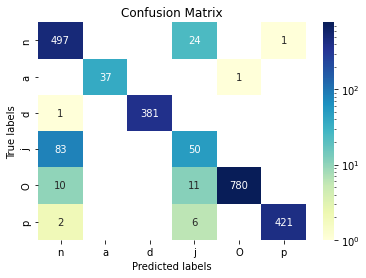

In [24]:
labels = ['n', 'a', 'd', 'j', 'O', 'p']
plot_confusion_matrix(y_test, y_pred, labels)

### evaluate censoring performance

In [25]:
blackout_labels = ["n","j","d","a"]
tok_anno_test['blackout_label'] = tok_anno_test['annotation'].apply(lambda x: x in blackout_labels)
tok_anno_test

,IDENTIFIER,td-idx,annotation,blackout_label
69,ID-11,69,n,True
70,ID-11,70,p,False
71,ID-11,71,O,False
72,ID-11,72,p,False
73,ID-11,73,O,False
...,...,...,...,...
11632,ID-999,11632,O,False
11633,ID-999,11633,O,False
11634,ID-999,11634,O,False
11635,ID-999,11635,O,False


In [26]:
y_test_blackout = tok_anno_test['blackout_label'].apply(lambda x: 'blackout' if x else 'open')
y_pred_blackout = test_preds['blackout_label'].apply(lambda x: 'blackout' if x else 'open')
print(metrics.classification_report(y_test_blackout, y_pred_blackout, digits=3))

              precision    recall  f1-score   support

    blackout      0.951     0.997     0.974      1076
        open      0.998     0.958     0.977      1300

    accuracy                          0.976      2376
   macro avg      0.974     0.977     0.975      2376
weighted avg      0.977     0.976     0.976      2376



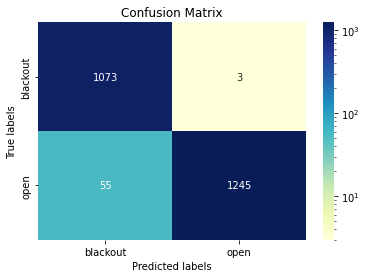

In [27]:
labels = ['blackout', 'open']
plot_confusion_matrix(y_test_blackout, y_pred_blackout, labels)

## K-fold cross validation (this takes some time!)

In [30]:
k = 3

kf = KFold(n_splits=k, random_state=None, shuffle=False)

kf_indices = dict()
kf_preds = dict()
kf_preds_proba = dict()
kf_scores = dict()


for i, (train_index, test_index) in enumerate(kf.split(doc_ids)):
    fold_number = i+1
    logging.info(f'Running fold number: {fold_number}')
    
    docs_train, docs_test = doc_ids[train_index], doc_ids[test_index]
    
    logging.info(f'Number documents train: {len(train_index)}; Number documentes test: {len(test_index)}')
    
    in_train_toks = tok_anno[id_field].isin(docs_train)
    in_train_docs = doc_anno[id_field].isin(docs_train)
    
    tok_feat_df_train = tok_feat_df[in_train_toks]  # training set features (token-level)
    tok_anno_train = tok_anno[in_train_toks]  # training set labels (token-level)
    tok_feat_df_test = tok_feat_df[~in_train_toks]  # test set features (token-level)
    tok_anno_test = tok_anno[~in_train_toks]  # test set labels (token-level)
    
    doc_feat_df_train = doc_feat_df[in_train_docs]  # training set features (document-level)
    doc_anno_train = doc_anno[in_train_docs]  # training set labels (document-level)
    doc_feat_df_test = doc_feat_df[~in_train_docs] # test set features (document-level)
    doc_anno_test = doc_feat_df[~in_train_docs]  # test set labels (document-level)
    
    idx_dict = {'train':docs_train, 'test':docs_test}
    
    crf_model, mlp_model, svm_model, vectorizer = train_classifiers(doc_feat_df_train,
                                                                doc_anno_train,
                                                                tok_feat_df_train,
                                                                tok_anno_train)

    models_dict = {'crf_model': crf_model, 'mlp_model': mlp_model, 'svm_model': svm_model, 'vectorizer': vectorizer}
    
    test_preds = models.predict_labels(doc_feat_df_test, tok_feat_df_test, id_field=id_field)
    
    
    kf_indices[f'run-{fold_number}'] = idx_dict
    kf_preds[f'run-{fold_number}'] = test_preds
    
    y_test = tok_anno_test['annotation']
    y_pred = test_preds['prediction']
    
    kf_scores[f'run-{fold_number}'] = metrics.classification_report(y_test, y_pred, digits=3, output_dict=True)
    
logging.info('Done.')
    

INFO:root:Running fold number: 1
INFO:root:Number documents train: 666; Number documentes test: 334
INFO:root:Training CRF classifier...
INFO:root:CRF model: training completed.
INFO:root:Training MLP Classifier...
INFO:root:MLP model: training completed.
INFO:root:Training SVM Classifier...
INFO:root:SVM model: training completed
INFO:root:Training of ensemble subsystems completed.
INFO:root:Applying models...
INFO:root:Ensembling...
INFO:root:Applying relabeling...
INFO:root:Done.
INFO:root:Running fold number: 2
INFO:root:Number documents train: 667; Number documentes test: 333
INFO:root:Training CRF classifier...
INFO:root:CRF model: training completed.
INFO:root:Training MLP Classifier...
INFO:root:MLP model: training completed.
INFO:root:Training SVM Classifier...
INFO:root:SVM model: training completed
INFO:root:Training of ensemble subsystems completed.
INFO:root:Applying models...
INFO:root:Ensembling...
INFO:root:Applying relabeling...
INFO:root:Done.
INFO:root:Running fold n

## Evaluate after k-fold cross validation

In [31]:
## Average evaluation scores (across folds)

cv_eval = pd.DataFrame(kf_scores).T

avg_eval = pd.DataFrame()

for c in cv_eval.columns:
    avg_eval[c] = cv_eval[c].apply(pd.Series).mean()
    
avg_eval.round(3)

,O,a,d,j,n,p,wd,accuracy,macro avg,weighted avg
precision,0.999,1.000,0.997,0.942,0.963,0.999,0.987,NaN,0.984,0.987
recall,0.993,0.994,0.999,0.883,0.990,0.996,0.983,NaN,0.977,0.987
f1-score,0.996,0.997,0.998,0.911,0.976,0.998,0.985,NaN,0.980,0.987
support,1257.333,61.667,642.000,239.333,843.000,671.333,172.000,NaN,3886.667,3886.667


In [32]:
#congregate predicted labels across all folds

preds_congregated = pd.DataFrame()

for run in kf_indices:
    run_labels = kf_preds[run]
    run_labels['run_id'] = run
    preds_congregated = preds_congregated.append(run_labels, ignore_index=True)
    
preds_congregated = preds_congregated.reset_index(drop=True)

preds_congregated

,IDENTIFIER,td-idx,token,prediction,blackout_label,run_id
0,ID-1,0,YU,O,False,run-1
1,ID-1,1,:,p,False,run-1
2,ID-1,2,Vahuret,j,True,run-1
3,ID-1,3,",",p,False,run-1
4,ID-1,4,Givisiez,O,False,run-1
...,...,...,...,...,...,...
11655,ID-1000,11655,.,wd,False,run-3
11656,ID-1000,11656,6,wd,False,run-3
11657,ID-1000,11657,.,wd,False,run-3
11658,ID-1000,11658,02,wd,False,run-3


### evaluate labels

In [33]:
y_test = tok_anno['annotation']
y_pred = preds_congregated['prediction']

print(metrics.classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           O      0.999     0.993     0.996      3772
           a      1.000     0.995     0.997       185
           d      0.997     0.999     0.998      1926
           j      0.939     0.884     0.911       718
           n      0.963     0.990     0.976      2529
           p      1.000     0.996     0.998      2014
          wd      0.986     0.983     0.984       516

    accuracy                          0.987     11660
   macro avg      0.983     0.977     0.980     11660
weighted avg      0.987     0.987     0.987     11660



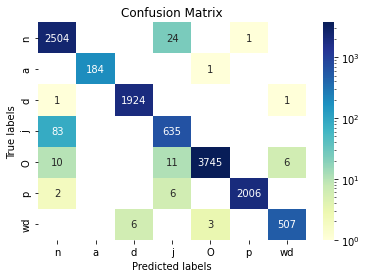

In [35]:
labels = ['n', 'a', 'd', 'j', 'O', 'p', 'wd']
plot_confusion_matrix(y_test, y_pred, labels)

### evaluate censoring performance

In [39]:
blackout_labels = ["n","j","d","a"]
tok_anno['blackout_label'] = tok_anno['annotation'].apply(lambda x: x in blackout_labels)
tok_anno

,IDENTIFIER,td-idx,annotation,blackout_label
0,ID-1,0,O,False
1,ID-1,1,p,False
2,ID-1,2,j,True
3,ID-1,3,p,False
4,ID-1,4,O,False
...,...,...,...,...
11655,ID-1000,11655,wd,False
11656,ID-1000,11656,wd,False
11657,ID-1000,11657,wd,False
11658,ID-1000,11658,wd,False


In [40]:
y_test_blackout = tok_anno['blackout_label'].apply(lambda x: 'blackout' if x else 'open')
y_pred_blackout = preds_congregated['blackout_label'].apply(lambda x: 'blackout' if x else 'open')
print(metrics.classification_report(y_test_blackout, y_pred_blackout, digits=3))

              precision    recall  f1-score   support

    blackout      0.977     0.999     0.988      5358
        open      1.000     0.980     0.990      6302

    accuracy                          0.989     11660
   macro avg      0.988     0.990     0.989     11660
weighted avg      0.989     0.989     0.989     11660



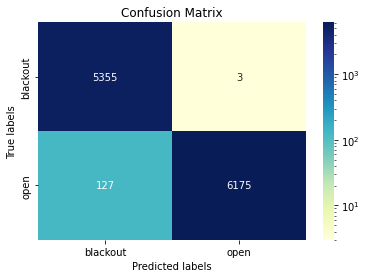

In [41]:
labels = ['blackout', 'open']
plot_confusion_matrix(y_test_blackout, y_pred_blackout, labels)